In [13]:
import numpy as np
import pickle
import torch
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import src.learning as lrn
from src.safetymaps import StaticSafetyMap, DynamicSafetyMap
from src.reachsteering import HdaGreedy, HdaReachSteering
from src.visualization import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

hidden_layers = [256, 256, 256]
nn_reach = lrn.NeuralReach(hidden_layers=hidden_layers)
nn_reach.load_state_dict(torch.load('../saved/controllable_set/reachset_train/20231115-025054/models_20231130-175526/mlp_reach/mlp_reach.pt'))
nn_reach.eval()

#sfmap_model = StaticSafetyMap(x_range=(-300, 300), y_range=(-300, 300), npoints=100)
sfmap_model = DynamicSafetyMap(x_range=(-300, 300), y_range=(-300, 300), npoints=100, relative_path="..")

x0_init = np.array([-100.0, 0.0, 1300.0, 20.0, 5, -55.0, lander.mwet])
tof = 60.0
T = 5.0
dt = 0.5

In [15]:
hda_greedy = HdaGreedy(lander, sfmap_model, nn_reach, border_sharpness=10.0)
hda_greedy.solve_hda(x0_init, tof, T, dt)

x0: [   0.    0. 1300.   20.    5.  -55. 1905.], tgo: 60.0
Greedy HDA optimized single leg: 1.783236026763916 sec
x0: [ 1.41185500e+02  3.08420288e+01  9.10399571e+02  8.61399931e+00
  1.31642798e+00 -2.24691382e+01  1.84495282e+03], tgo: 50.0
Greedy HDA optimized single leg: 1.5199406147003174 sec
x0: [ 1.89669321e+02  4.24701871e+01  8.18163305e+02  2.55479173e+00
  1.05766234e+00 -6.78528738e+00  1.80104519e+03], tgo: 40.0
Greedy HDA optimized single leg: 1.1339716911315918 sec
x0: [ 2.03567066e+02  5.15115963e+01  7.02911646e+02  3.69104565e-01
  7.59420185e-01 -1.62058291e+01  1.77851009e+03], tgo: 30.0
Greedy HDA optimized single leg: 0.7041194438934326 sec
x0: [ 1.99592173e+02  5.77029816e+01  4.95364118e+02 -8.37891165e-01
  5.03977878e-01 -2.52283878e+01  1.75598458e+03], tgo: 20.0
Greedy HDA optimized single leg: 0.5974948406219482 sec


<module 'matplotlib.pyplot' from 'c:\\Users\\ktomita3\\.conda\\envs\\pygmo3\\lib\\site-packages\\matplotlib\\pyplot.py'>

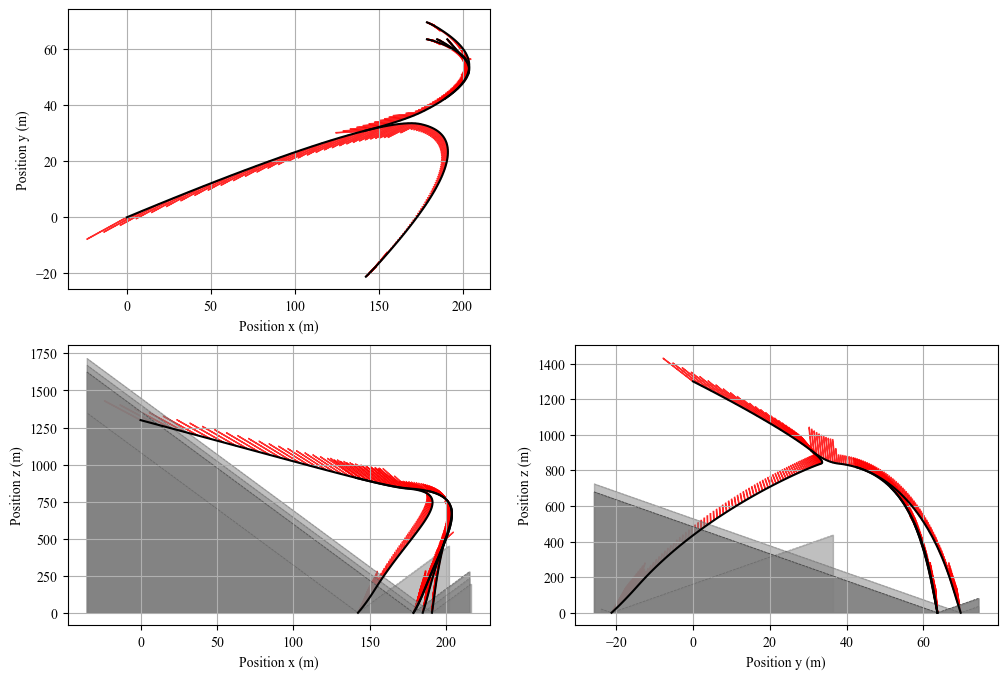

In [16]:
n_traj = len(hda_greedy.X_list)
fig, axs = None, None
for i in range(n_traj):
    t = hda_greedy.t_list[i]
    X = hda_greedy.X_list[i]
    U = hda_greedy.U_list[i]
    fig, axs = plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa, fig=fig, axs=axs)
plt

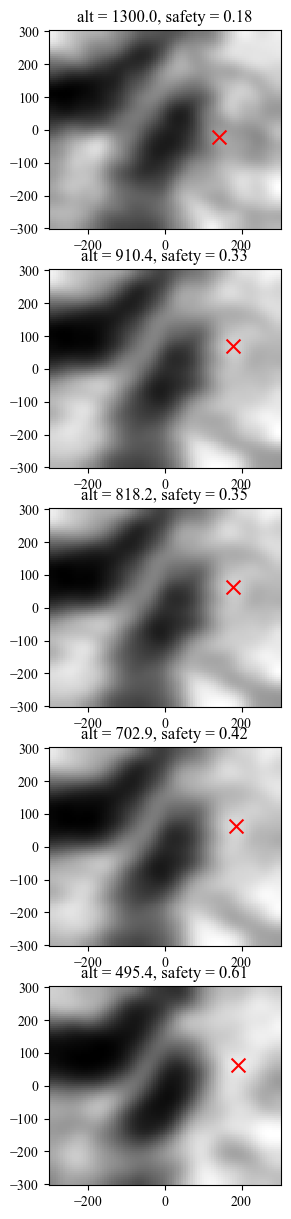

In [17]:
target_history = hda_greedy.target_list

# visualize safety map with target coordinates
fig, axs = plt.subplots(n_traj, 1, figsize=(3, 3 * n_traj))
for i in range(n_traj):
    x0 = hda_greedy.X_list[i][0]
    alt = x0[2]
    target = target_history[i]
    xt, yt = target[0], target[1]
    safety = target[2]

    # prep safety map
    sfmap = sfmap_model.get_sfmap(alt)
    n = int(np.sqrt(sfmap.shape[0]))
    x = sfmap[:, 0].reshape(n, n)
    y = sfmap[:, 1].reshape(n, n)
    z = sfmap[:, 2].reshape(n, n)
    safety_img = axs[i].pcolormesh(x, y, z, shading='auto', cmap='gray')
    axs[i].scatter(xt, yt, c='r', marker='x', s=100)
    axs[i].set_title(f'alt = {alt:.1f}, safety = {safety:.2f}')
plt.show()



    

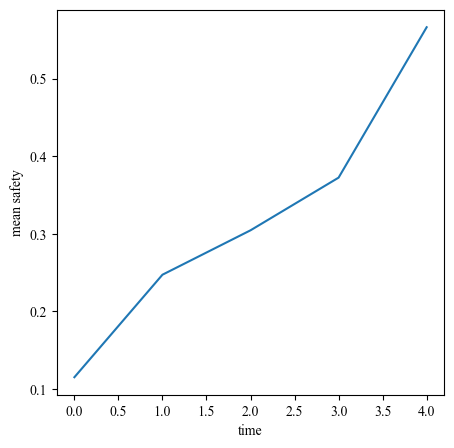

In [18]:
plt.figure(figsize=(5, 5))
plt.plot(np.arange(n_traj), hda_greedy.mean_safety_list)
plt.xlabel('time')
plt.ylabel('mean safety')
plt.show()

In [19]:
hda_rs = HdaReachSteering(lander, sfmap_model, nn_reach, border_sharpness=10.0)
hda_rs.solve_hda(x0_init, tof, T, dt)

x0: [   0.    0. 1300.   20.    5.  -55. 1905.], tgo: 60.0
Greedy HDA optimized single leg: 1.8111217021942139 sec
Reach-steering HDA optimized single leg: 411.41918563842773 sec
x0: [ 1.41185054e+02  3.08418847e+01  9.10402307e+02  8.61386558e+00
  1.31638505e+00 -2.24682844e+01  1.84490472e+03], tgo: 50.0
Greedy HDA optimized single leg: 1.37931489944458 sec
Reach-steering HDA optimized single leg: 113.19829654693604 sec
x0: [ 1.89668023e+02  4.24698405e+01  8.18171084e+02  2.55483430e+00
  1.05765998e+00 -6.78584808e+00  1.80096891e+03], tgo: 40.0
Greedy HDA optimized single leg: 1.2716023921966553 sec
Reach-steering HDA optimized single leg: 26.756539583206177 sec
x0: [ 2.03566809e+02  5.15113569e+01  7.02908663e+02  3.69171032e-01
  7.59430334e-01 -1.62063114e+01  1.77842765e+03], tgo: 30.0
Greedy HDA optimized single leg: 0.7590084075927734 sec
Reach-steering HDA optimized single leg: 9.181517839431763 sec
x0: [ 2.05978564e+02  6.05071020e+01  4.90635361e+02 -6.39294468e+00
  8.5

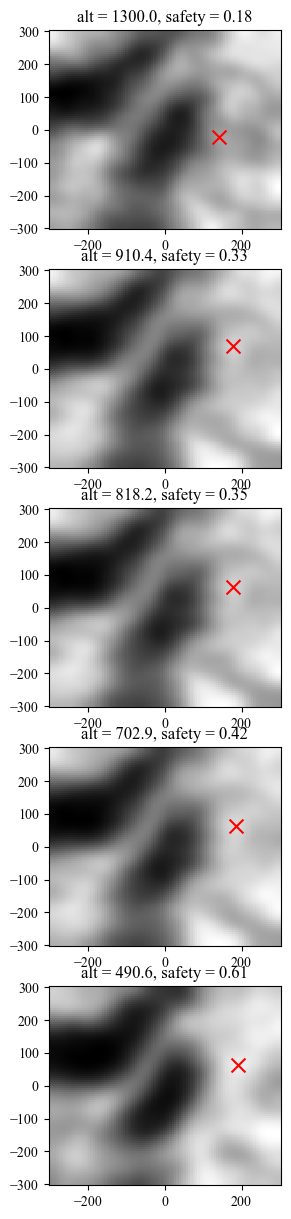

In [20]:
target_history = hda_rs.target_list
n_traj = len(hda_rs.X_list)

# visualize safety map with target coordinates
fig, axs = plt.subplots(n_traj, 1, figsize=(3, 3 * n_traj))
for i in range(n_traj):
    x0 = hda_rs.X_list[i][0]
    alt = x0[2]
    target = target_history[i]
    xt, yt = target[0], target[1]
    safety = target[2]

    # prep safety map
    sfmap = sfmap_model.get_sfmap(alt)
    n = int(np.sqrt(sfmap.shape[0]))
    x = sfmap[:, 0].reshape(n, n)
    y = sfmap[:, 1].reshape(n, n)
    z = sfmap[:, 2].reshape(n, n)
    safety_img = axs[i].pcolormesh(x, y, z, shading='auto', cmap='gray')
    axs[i].scatter(xt, yt, c='r', marker='x', s=100)
    axs[i].set_title(f'alt = {alt:.1f}, safety = {safety:.2f}')
plt.show()



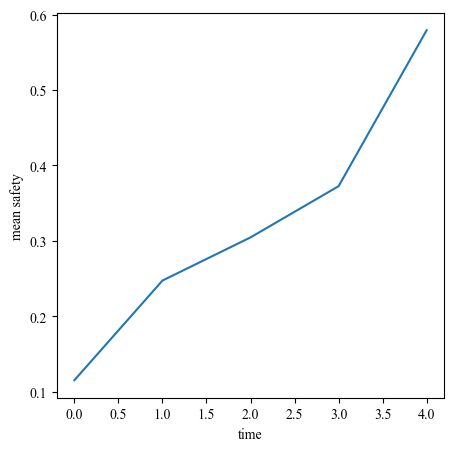

In [21]:
plt.figure(figsize=(5, 5))
plt.plot(np.arange(n_traj), hda_rs.mean_safety_list)
plt.xlabel('time')
plt.ylabel('mean safety')
plt.show()

In [22]:
t, X, U = hda_rs.construct_trajectory()

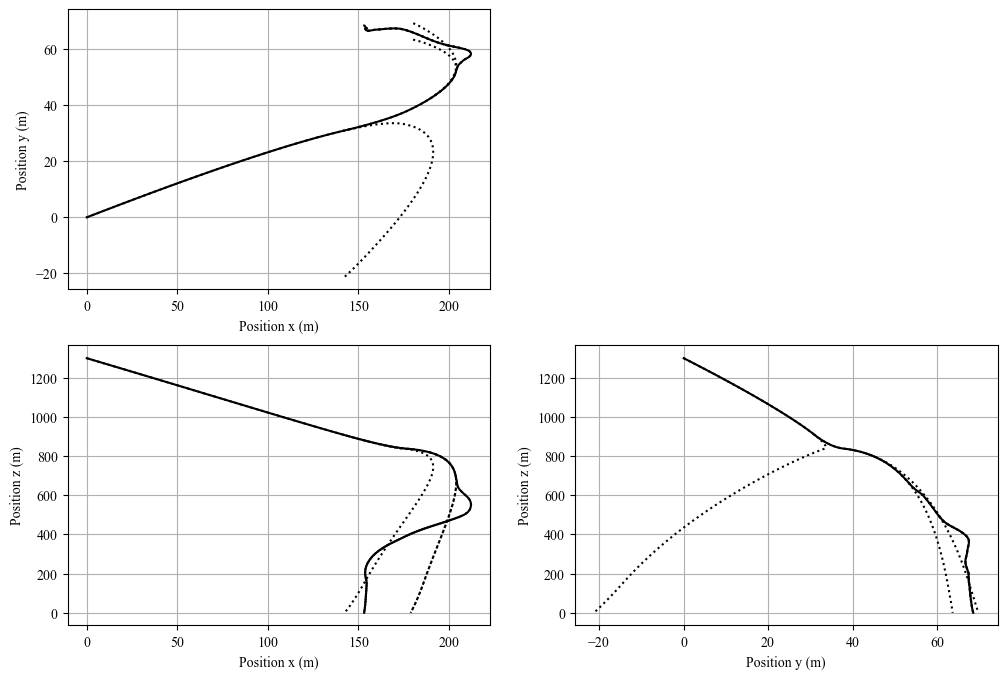

In [23]:
fig, axs = plot_3sides(t[:-1], X, U=None, uskip=1)
n_traj = len(hda_rs.X_list)
for i in range(n_traj):
    t_ = hda_rs.t_list[i]
    X_ = hda_rs.X_list[i]
    U_ = hda_rs.U_list[i]
    fig, axs = plot_3sides(t_[:-1], X_, U=None, uskip=1, fig=fig, axs=axs, linetype='k:')

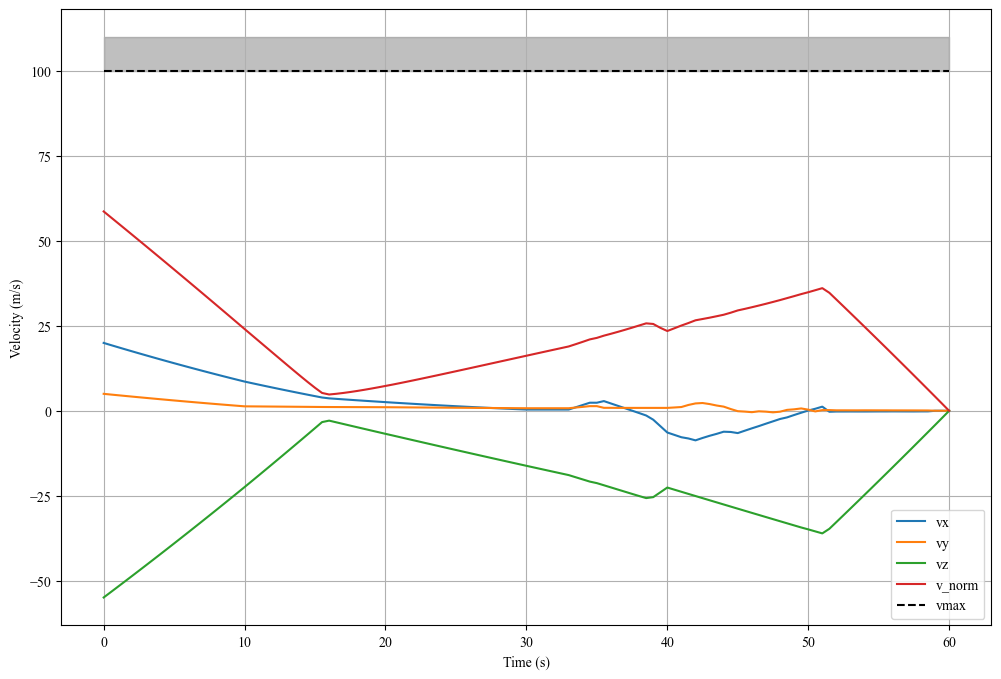

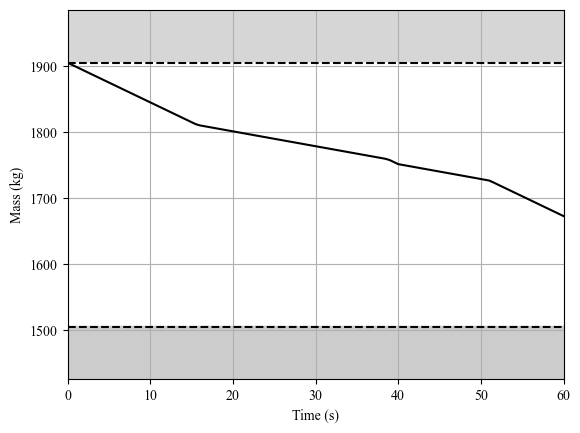

(120,)


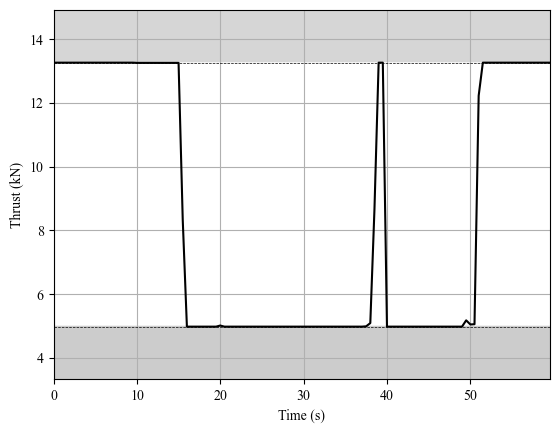

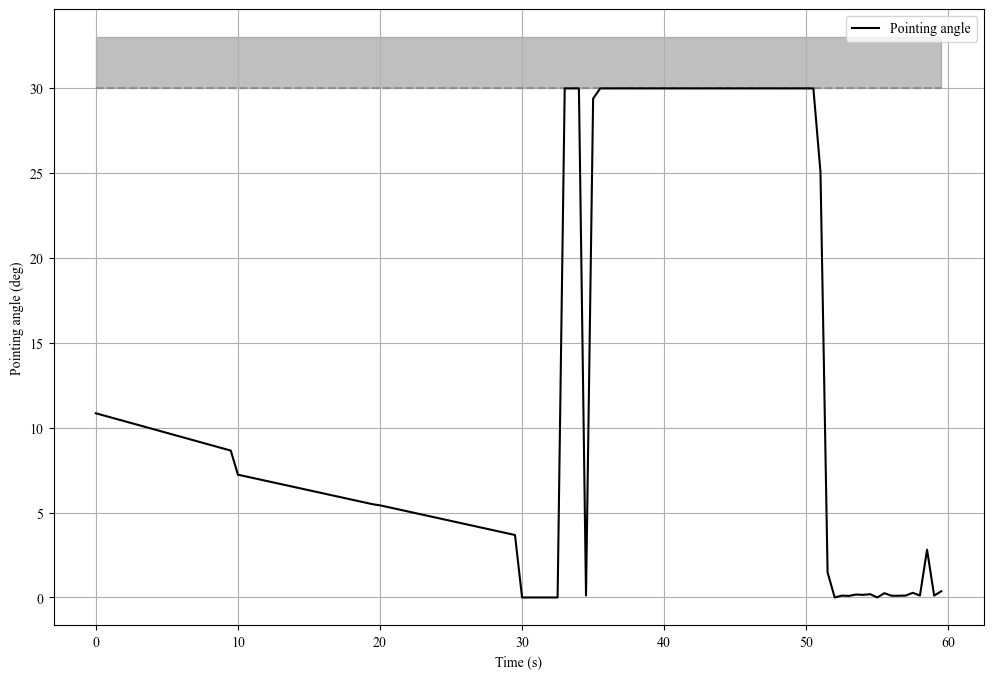

In [24]:
plot_vel(t, X, lander.vmax)

plot_mass(t, X, lander.mdry, lander.mwet)

plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)

plot_pointing(t[:-1], U, lander.pa)

In [25]:
print(hda_greedy.mean_safety_list)
print(hda_rs.mean_safety_list)

[0.11523707507951554, 0.2473392307395674, 0.3045665335071569, 0.37243779988459996, 0.5662663125130273]
[0.11523707507951554, 0.2473383625295995, 0.30456537730551064, 0.3724376792195146, 0.579192996048821]
